=== DEMOSTRACIÓN DE BOOTSTRAP SAMPLING ===

Datos originales - Tamaño: 100
Media original: 1.8295
Desviación estándar original: 1.8304

1. Bootstrap para estimación de la media:
Media de medias bootstrap: 1.8414
Error estándar bootstrap: 0.1806

2. Intervalo de confianza (95%):
Media original: 1.8295
IC 95%: [1.4832, 2.2086]

3. Bootstrap para diferentes estadísticas:
Mediana:
  Original: 1.2480
  Bootstrap media: 1.2314
  Bootstrap std: 0.2271
Desviación estándar:
  Original: 1.8304
  Bootstrap media: 1.8278
  Bootstrap std: 0.1797
Percentil 75:
  Original: 2.6202
  Bootstrap media: 2.6487
  Bootstrap std: 0.3065
Coeficiente de variación:
  Original: 1.0005
  Bootstrap media: 0.9893
  Bootstrap std: 0.0709


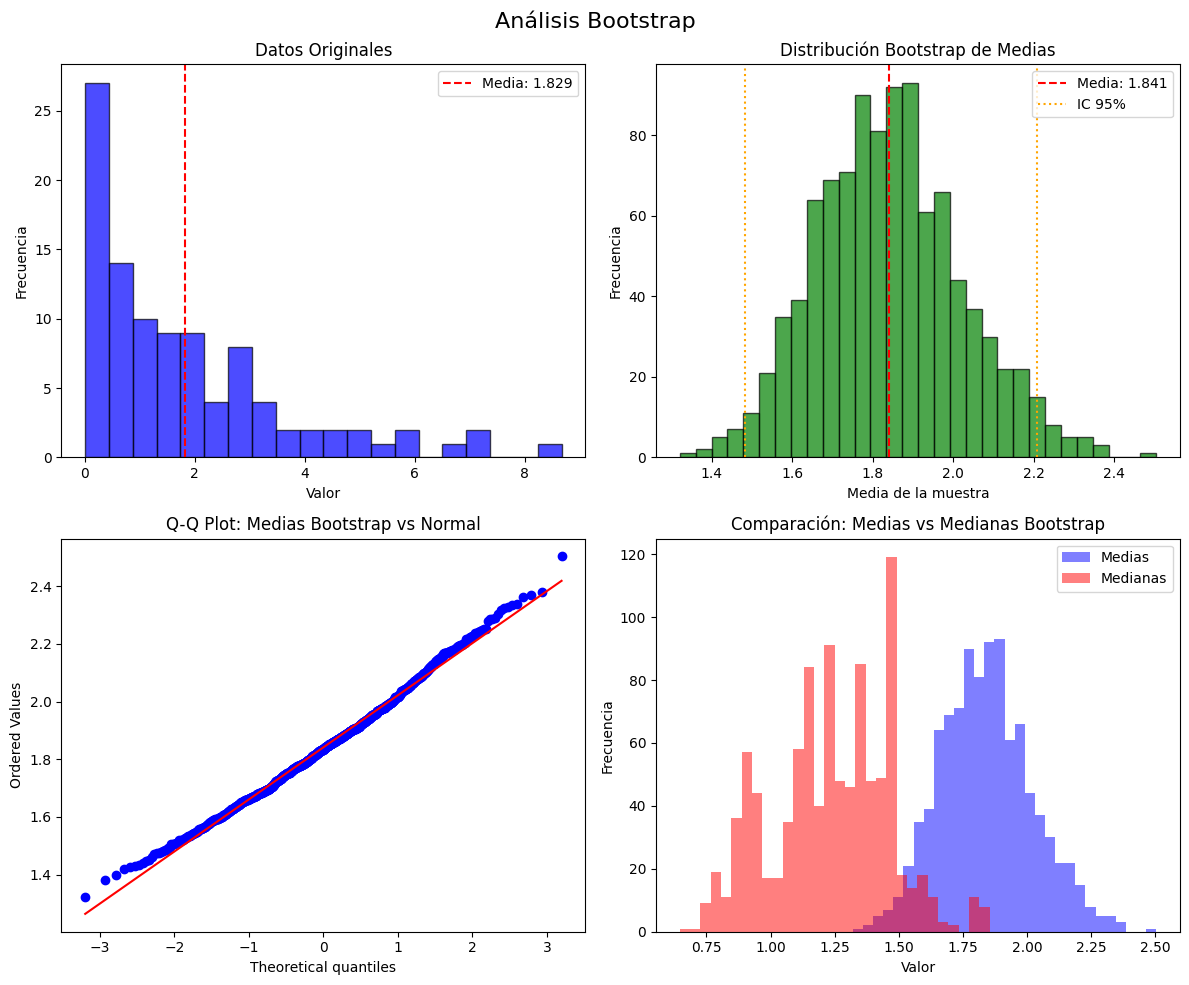


5. Verificación de aleatoriedad:
Sampler 1 (seed=123): [1.53733956 0.85675522 2.06339727 1.0608742  1.98176339]
Sampler 2 (seed=456): [1.79788561 1.59382927 1.71065954 1.5268469  1.35348649]
Sampler 3 (seed=123): [1.53733956 0.85675522 2.06339727 1.0608742  1.98176339]
Sampler 1 == Sampler 3: True
Sampler 1 == Sampler 2: False


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random

class BootstrapSampler:
    """
    Clase para realizar muestreo bootstrap con principios sólidos de aleatoriedad
    """

    def __init__(self, seed=None):
        """
        Inicializa el generador de números aleatorios

        Args:
            seed (int, optional): Semilla para reproducibilidad
        """
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        # Usar generador de números aleatorios más robusto
        self.rng = np.random.default_rng(seed)

    def bootstrap_sample(self, data, n_bootstrap=1000, sample_size=None, statistic=np.mean):
        """
        Realiza muestreo bootstrap sobre los datos

        Args:
            data (array-like): Datos originales
            n_bootstrap (int): Número de muestras bootstrap
            sample_size (int, optional): Tamaño de cada muestra bootstrap
            statistic (function): Estadística a calcular (por defecto: media)

        Returns:
            numpy.ndarray: Estadísticas calculadas para cada muestra bootstrap
        """
        data = np.array(data)
        n = len(data)

        # Si no se especifica tamaño de muestra, usar el mismo que los datos originales
        if sample_size is None:
            sample_size = n

        bootstrap_stats = np.zeros(n_bootstrap)

        for i in range(n_bootstrap):
            # Muestreo con reemplazo usando generador robusto
            bootstrap_indices = self.rng.choice(n, size=sample_size, replace=True)
            bootstrap_sample = data[bootstrap_indices]

            # Calcular estadística
            bootstrap_stats[i] = statistic(bootstrap_sample)

        return bootstrap_stats

    def bootstrap_confidence_interval(self, data, statistic=np.mean,
                                    confidence_level=0.95, n_bootstrap=1000):
        """
        Calcula intervalo de confianza usando bootstrap

        Args:
            data (array-like): Datos originales
            statistic (function): Estadística a calcular
            confidence_level (float): Nivel de confianza (0-1)
            n_bootstrap (int): Número de muestras bootstrap

        Returns:
            tuple: (estadística_original, límite_inferior, límite_superior)
        """
        bootstrap_stats = self.bootstrap_sample(data, n_bootstrap, statistic=statistic)

        # Calcular percentiles para el intervalo de confianza
        alpha = 1 - confidence_level
        lower_percentile = (alpha / 2) * 100
        upper_percentile = (1 - alpha / 2) * 100

        ci_lower = np.percentile(bootstrap_stats, lower_percentile)
        ci_upper = np.percentile(bootstrap_stats, upper_percentile)

        original_stat = statistic(data)

        return original_stat, ci_lower, ci_upper

    def stratified_bootstrap(self, data, strata, n_bootstrap=1000, statistic=np.mean):
        """
        Bootstrap estratificado para mantener proporciones de grupos

        Args:
            data (array-like): Datos
            strata (array-like): Identificadores de estratos
            n_bootstrap (int): Número de muestras bootstrap
            statistic (function): Estadística a calcular

        Returns:
            numpy.ndarray: Estadísticas bootstrap
        """
        data = np.array(data)
        strata = np.array(strata)
        unique_strata = np.unique(strata)

        bootstrap_stats = np.zeros(n_bootstrap)

        for i in range(n_bootstrap):
            bootstrap_sample = []

            # Muestrear de cada estrato manteniendo proporciones
            for stratum in unique_strata:
                stratum_mask = strata == stratum
                stratum_data = data[stratum_mask]
                stratum_size = len(stratum_data)

                # Muestreo con reemplazo dentro del estrato
                if stratum_size > 0:
                    stratum_indices = self.rng.choice(
                        stratum_size, size=stratum_size, replace=True
                    )
                    bootstrap_sample.extend(stratum_data[stratum_indices])

            bootstrap_stats[i] = statistic(bootstrap_sample)

        return bootstrap_stats


# Ejemplo de uso y demostración
def demo_bootstrap():
    """
    Demostración del muestreo bootstrap
    """
    # Generar datos de ejemplo con distribución no normal
    np.random.seed(42)

    # Datos con distribución exponencial
    original_data = np.random.exponential(scale=2, size=100)

    # Crear instancia del bootstrap sampler
    bootstrap_sampler = BootstrapSampler(seed=42)

    print("=== DEMOSTRACIÓN DE BOOTSTRAP SAMPLING ===\n")
    print(f"Datos originales - Tamaño: {len(original_data)}")
    print(f"Media original: {np.mean(original_data):.4f}")
    print(f"Desviación estándar original: {np.std(original_data):.4f}")

    # 1. Bootstrap básico para la media
    print("\n1. Bootstrap para estimación de la media:")
    bootstrap_means = bootstrap_sampler.bootstrap_sample(
        original_data, n_bootstrap=1000, statistic=np.mean
    )

    print(f"Media de medias bootstrap: {np.mean(bootstrap_means):.4f}")
    print(f"Error estándar bootstrap: {np.std(bootstrap_means):.4f}")

    # 2. Intervalo de confianza
    print("\n2. Intervalo de confianza (95%):")
    original_mean, ci_lower, ci_upper = bootstrap_sampler.bootstrap_confidence_interval(
        original_data, confidence_level=0.95
    )
    print(f"Media original: {original_mean:.4f}")
    print(f"IC 95%: [{ci_lower:.4f}, {ci_upper:.4f}]")

    # 3. Bootstrap para diferentes estadísticas
    print("\n3. Bootstrap para diferentes estadísticas:")
    statistics = {
        'Mediana': np.median,
        'Desviación estándar': np.std,
        'Percentil 75': lambda x: np.percentile(x, 75),
        'Coeficiente de variación': lambda x: np.std(x) / np.mean(x)
    }

    for stat_name, stat_func in statistics.items():
        bootstrap_stats = bootstrap_sampler.bootstrap_sample(
            original_data, n_bootstrap=1000, statistic=stat_func
        )
        original_stat = stat_func(original_data)
        bootstrap_mean = np.mean(bootstrap_stats)
        bootstrap_std = np.std(bootstrap_stats)

        print(f"{stat_name}:")
        print(f"  Original: {original_stat:.4f}")
        print(f"  Bootstrap media: {bootstrap_mean:.4f}")
        print(f"  Bootstrap std: {bootstrap_std:.4f}")

    # 4. Visualización
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Análisis Bootstrap', fontsize=16)

    # Datos originales
    axes[0, 0].hist(original_data, bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].axvline(np.mean(original_data), color='red', linestyle='--',
                       label=f'Media: {np.mean(original_data):.3f}')
    axes[0, 0].set_title('Datos Originales')
    axes[0, 0].set_xlabel('Valor')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].legend()

    # Distribución bootstrap de medias
    axes[0, 1].hist(bootstrap_means, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].axvline(np.mean(bootstrap_means), color='red', linestyle='--',
                       label=f'Media: {np.mean(bootstrap_means):.3f}')
    axes[0, 1].axvline(ci_lower, color='orange', linestyle=':', label=f'IC 95%')
    axes[0, 1].axvline(ci_upper, color='orange', linestyle=':')
    axes[0, 1].set_title('Distribución Bootstrap de Medias')
    axes[0, 1].set_xlabel('Media de la muestra')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].legend()

    # Q-Q plot para normalidad de bootstrap
    bootstrap_medianas = bootstrap_sampler.bootstrap_sample(
        original_data, n_bootstrap=1000, statistic=np.median
    )
    stats.probplot(bootstrap_means, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot: Medias Bootstrap vs Normal')

    # Comparación de estadísticas bootstrap
    bootstrap_medians = bootstrap_sampler.bootstrap_sample(
        original_data, n_bootstrap=1000, statistic=np.median
    )
    axes[1, 1].hist(bootstrap_means, bins=30, alpha=0.5, label='Medias', color='blue')
    axes[1, 1].hist(bootstrap_medians, bins=30, alpha=0.5, label='Medianas', color='red')
    axes[1, 1].set_title('Comparación: Medias vs Medianas Bootstrap')
    axes[1, 1].set_xlabel('Valor')
    axes[1, 1].set_ylabel('Frecuencia')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    # 5. Demostración de principios de aleatoriedad
    print("\n5. Verificación de aleatoriedad:")

    # Comparar con diferentes semillas
    sampler1 = BootstrapSampler(seed=123)
    sampler2 = BootstrapSampler(seed=456)
    sampler3 = BootstrapSampler(seed=123)  # Misma semilla que sampler1

    bootstrap1 = sampler1.bootstrap_sample(original_data[:20], n_bootstrap=5)
    bootstrap2 = sampler2.bootstrap_sample(original_data[:20], n_bootstrap=5)
    bootstrap3 = sampler3.bootstrap_sample(original_data[:20], n_bootstrap=5)

    print(f"Sampler 1 (seed=123): {bootstrap1}")
    print(f"Sampler 2 (seed=456): {bootstrap2}")
    print(f"Sampler 3 (seed=123): {bootstrap3}")
    print(f"Sampler 1 == Sampler 3: {np.allclose(bootstrap1, bootstrap3)}")
    print(f"Sampler 1 == Sampler 2: {np.allclose(bootstrap1, bootstrap2)}")


if __name__ == "__main__":
    demo_bootstrap()

Base de datos 'empresa_ejemplo.db' creada con 1500 empleados
=== ANÁLISIS BOOTSTRAP DE BASE DE DATOS ===

Dataset cargado: 1500 registros
Columnas: ['id', 'nombre', 'departamento', 'salario', 'edad', 'experiencia', 'genero', 'fecha_ingreso', 'ciudad', 'nivel_educacion', 'evaluacion_performance']

1. ANÁLISIS DE SALARIOS
------------------------------
Salario promedio original: $55,513.15
Mediana salarial original: $53,520.33
Desv. estándar original: $16,844.50

Bootstrap - Media de medias: $55,510.77
Error estándar bootstrap: $447.40
IC 95% para salario medio: [$54,668.96, $56,448.29]

2. ANÁLISIS POR DEPARTAMENTO
-----------------------------------
Finanzas (n=231):
  Media: $58,905.52
  IC 95%: [$56,613.38, $61,049.71]
RRHH (n=152):
  Media: $49,302.70
  IC 95%: [$47,141.65, $51,203.08]
Operaciones (n=236):
  Media: $48,264.22
  IC 95%: [$46,574.39, $49,796.51]
Marketing (n=224):
  Media: $55,231.95
  IC 95%: [$53,345.53, $57,066.72]
IT (n=364):
  Media: $62,863.12
  IC 95%: [$60,981

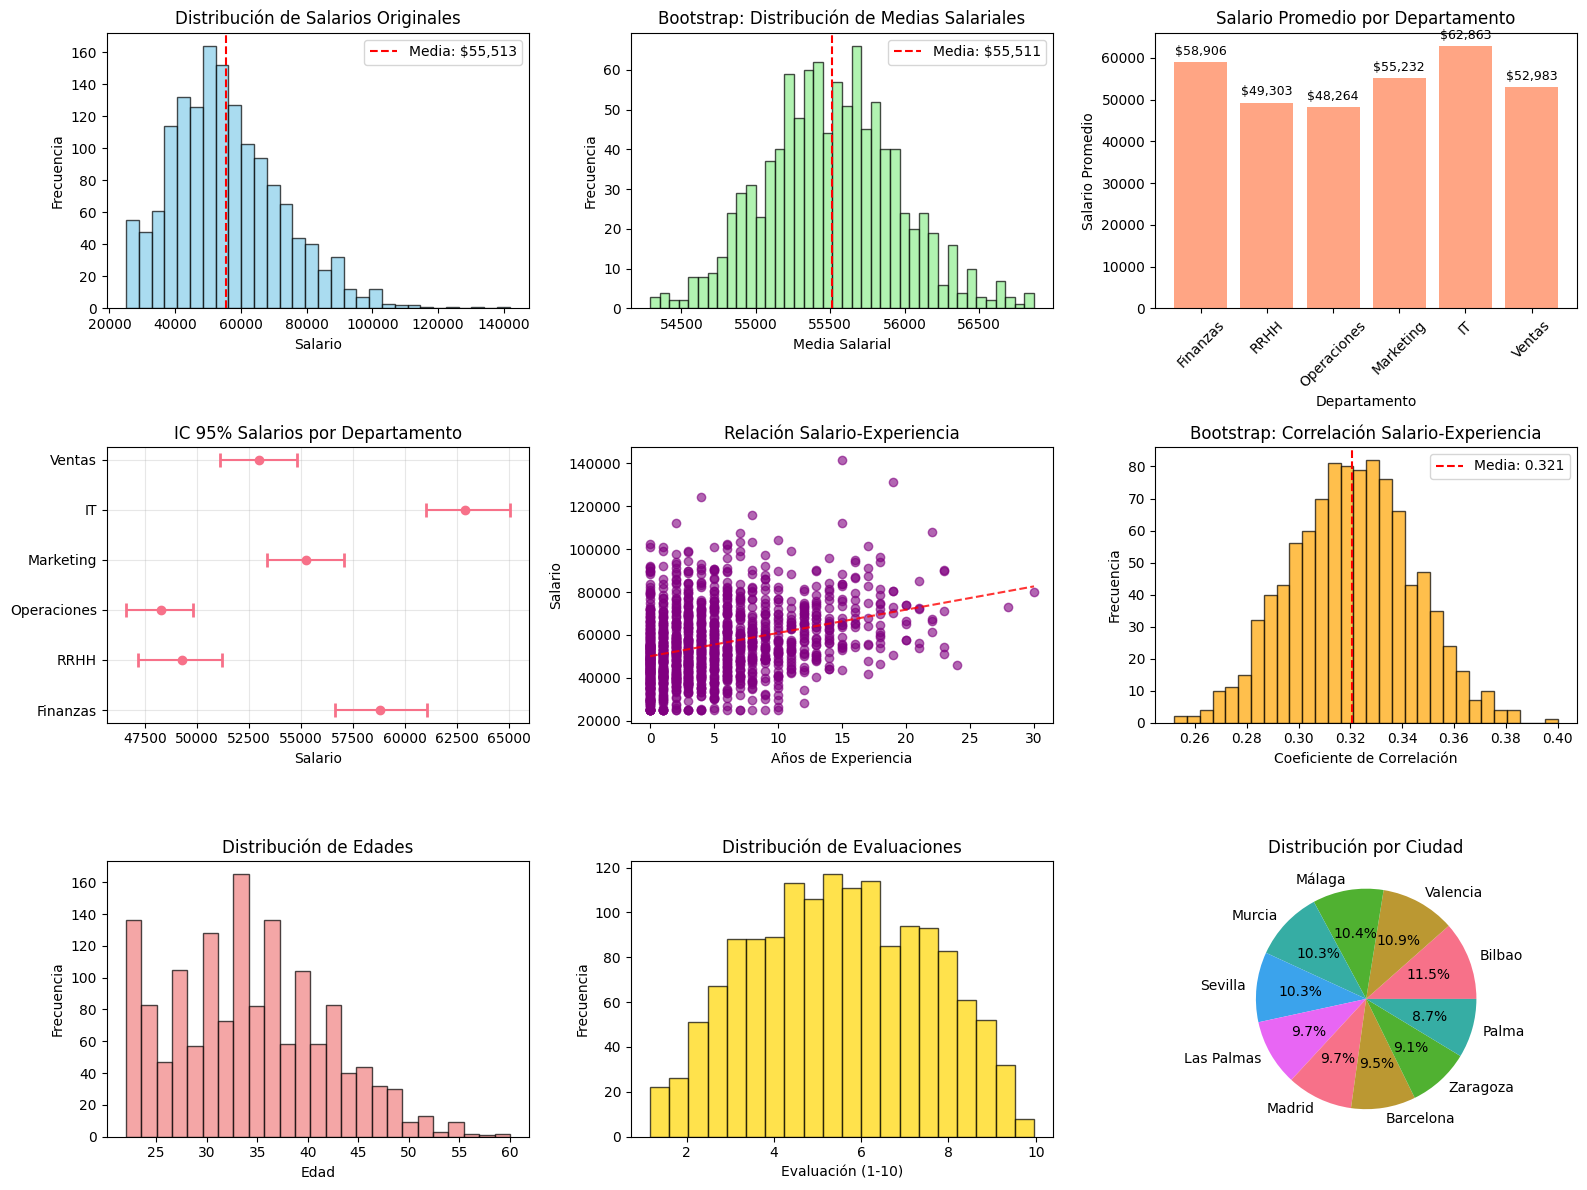


4. ANÁLISIS ADICIONALES
-------------------------

Análisis por género:
M (n=764):
  Media: $55,639.24
  IC 95%: [$54,439.56, $56,926.48]
F (n=736):
  Media: $55,382.27
  IC 95%: [$54,245.65, $56,581.66]

Consulta personalizada - Empleados IT con >5 años experiencia:
Registros encontrados: 138
Salario promedio IT experimentado: $66,802.32
IC 95%: [$63,643.22, $70,007.75]

¡Análisis completado! La base de datos 'empresa_ejemplo.db' ha sido creada.
Puedes usar este código como base para analizar tus propias bases de datos.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sqlite3
from datetime import datetime, timedelta
import random

class DatabaseBootstrap:
    """
    Clase para realizar muestreo bootstrap sobre bases de datos
    """

    def __init__(self, seed=None):
        """
        Inicializa el generador de números aleatorios

        Args:
            seed (int, optional): Semilla para reproducibilidad
        """
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        self.rng = np.random.default_rng(seed)
        self.db_connection = None

    def create_sample_database(self, db_name='empresa.db', n_employees=1000):
        """
        Crea una base de datos de ejemplo con empleados de una empresa

        Args:
            db_name (str): Nombre del archivo de base de datos
            n_employees (int): Número de empleados a generar
        """
        # Cerrar cualquier conexión previa si existe
        if hasattr(self, 'db_connection') and self.db_connection:
            self.db_connection.close()

        # Eliminar archivo de base de datos si existe para evitar conflictos
        import os
        if os.path.exists(db_name):
            try:
                os.remove(db_name)
            except:
                pass

        # Crear conexión a SQLite con timeout
        conn = sqlite3.connect(db_name, timeout=30.0)
        cursor = conn.cursor()

        # Crear tabla de empleados
        cursor.execute('''
            CREATE TABLE empleados (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                nombre TEXT NOT NULL,
                departamento TEXT NOT NULL,
                salario REAL NOT NULL,
                edad INTEGER NOT NULL,
                experiencia INTEGER NOT NULL,
                genero TEXT NOT NULL,
                fecha_ingreso DATE NOT NULL,
                ciudad TEXT NOT NULL,
                nivel_educacion TEXT NOT NULL,
                evaluacion_performance REAL NOT NULL
            )
        ''')

        # Datos para generar empleados realistas
        nombres = ['Ana', 'Carlos', 'María', 'Juan', 'Laura', 'Pedro', 'Carmen', 'Luis',
                  'Isabel', 'Miguel', 'Sofía', 'Diego', 'Patricia', 'Roberto', 'Elena',
                  'Fernando', 'Lucía', 'Andrés', 'Mónica', 'Javier']
        apellidos = ['García', 'Martínez', 'López', 'González', 'Rodríguez', 'Sánchez',
                    'Pérez', 'Martín', 'Gómez', 'Fernández', 'Díaz', 'Ruiz', 'Hernández',
                    'Jiménez', 'Álvarez', 'Moreno', 'Muñoz', 'Alonso', 'Romero', 'Navarro']

        departamentos = {
            'IT': {'peso': 0.25, 'salario_base': 55000, 'salario_std': 15000},
            'Ventas': {'peso': 0.20, 'salario_base': 45000, 'salario_std': 12000},
            'Marketing': {'peso': 0.15, 'salario_base': 48000, 'salario_std': 10000},
            'RRHH': {'peso': 0.10, 'salario_base': 42000, 'salario_std': 8000},
            'Finanzas': {'peso': 0.15, 'salario_base': 52000, 'salario_std': 13000},
            'Operaciones': {'peso': 0.15, 'salario_base': 40000, 'salario_std': 9000}
        }

        ciudades = ['Madrid', 'Barcelona', 'Valencia', 'Sevilla', 'Zaragoza', 'Málaga',
                   'Murcia', 'Palma', 'Las Palmas', 'Bilbao']

        niveles_educacion = ['Bachillerato', 'FP', 'Universitario', 'Máster', 'Doctorado']
        generos = ['M', 'F']

        # Generar empleados
        empleados_data = []
        fecha_base = datetime(2020, 1, 1)

        for i in range(n_employees):
            # Seleccionar departamento según pesos
            dept_names = list(departamentos.keys())
            dept_weights = [departamentos[d]['peso'] for d in dept_names]
            departamento = self.rng.choice(dept_names, p=dept_weights)

            # Generar datos correlacionados
            edad = self.rng.normal(35, 8)
            edad = max(22, min(65, int(edad)))  # Limitar edad entre 22 y 65

            experiencia = max(0, min(edad - 22, int(self.rng.exponential(8))))

            # Salario basado en departamento, experiencia y educación
            nivel_edu = self.rng.choice(niveles_educacion,
                                      p=[0.1, 0.2, 0.4, 0.25, 0.05])
            edu_multiplier = {'Bachillerato': 0.8, 'FP': 0.9, 'Universitario': 1.0,
                            'Máster': 1.2, 'Doctorado': 1.4}

            salario_base = departamentos[departamento]['salario_base']
            salario_std = departamentos[departamento]['salario_std']
            salario = salario_base + (experiencia * 1200) + self.rng.normal(0, salario_std)
            salario *= edu_multiplier[nivel_edu]
            salario = max(25000, salario)  # Salario mínimo

            # Evaluación de performance (1-10)
            performance = self.rng.beta(2, 2) * 9 + 1  # Beta para distribución más realista

            # Fecha de ingreso
            dias_desde_base = int(self.rng.integers(0, (datetime.now() - fecha_base).days))
            fecha_ingreso = fecha_base + timedelta(days=dias_desde_base)

            empleado = (
                f"{self.rng.choice(nombres)} {self.rng.choice(apellidos)}",
                departamento,
                round(salario, 2),
                edad,
                experiencia,
                self.rng.choice(generos),
                fecha_ingreso.strftime('%Y-%m-%d'),
                self.rng.choice(ciudades),
                nivel_edu,
                round(performance, 2)
            )

            empleados_data.append(empleado)

        # Insertar datos
        cursor.executemany('''
            INSERT INTO empleados (nombre, departamento, salario, edad, experiencia,
                                 genero, fecha_ingreso, ciudad, nivel_educacion,
                                 evaluacion_performance)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', empleados_data)

        conn.commit()
        conn.close()

        print(f"Base de datos '{db_name}' creada con {n_employees} empleados")
        return db_name

    def load_data_from_db(self, db_name, query=None):
        """
        Carga datos desde la base de datos

        Args:
            db_name (str): Nombre del archivo de base de datos
            query (str, optional): Consulta SQL personalizada

        Returns:
            pandas.DataFrame: Datos cargados
        """
        if query is None:
            query = "SELECT * FROM empleados"

        # Usar context manager para manejo automático de conexiones
        try:
            with sqlite3.connect(db_name, timeout=30.0) as conn:
                df = pd.read_sql_query(query, conn)
            return df
        except Exception as e:
            print(f"Error al cargar datos: {e}")
            return pd.DataFrame()

    def bootstrap_database_sample(self, df, column, n_bootstrap=1000,
                                statistic=np.mean, group_by=None):
        """
        Realiza bootstrap sobre una columna de la base de datos

        Args:
            df (pandas.DataFrame): DataFrame con los datos
            column (str): Nombre de la columna a analizar
            n_bootstrap (int): Número de muestras bootstrap
            statistic (function): Estadística a calcular
            group_by (str, optional): Columna para agrupar (bootstrap estratificado)

        Returns:
            numpy.ndarray: Estadísticas bootstrap
        """
        if group_by is None:
            # Bootstrap simple
            data = df[column].values
            return self._simple_bootstrap(data, n_bootstrap, statistic)
        else:
            # Bootstrap estratificado por grupo
            return self._stratified_bootstrap(df, column, group_by, n_bootstrap, statistic)

    def _simple_bootstrap(self, data, n_bootstrap, statistic):
        """Bootstrap simple"""
        bootstrap_stats = np.zeros(n_bootstrap)
        n = len(data)

        for i in range(n_bootstrap):
            indices = self.rng.choice(n, size=n, replace=True)
            bootstrap_sample = data[indices]
            bootstrap_stats[i] = statistic(bootstrap_sample)

        return bootstrap_stats

    def _stratified_bootstrap(self, df, column, group_by, n_bootstrap, statistic):
        """Bootstrap estratificado"""
        bootstrap_stats = np.zeros(n_bootstrap)
        groups = df.groupby(group_by)

        for i in range(n_bootstrap):
            bootstrap_sample = []

            for name, group in groups:
                group_data = group[column].values
                group_size = len(group_data)

                if group_size > 0:
                    indices = self.rng.choice(group_size, size=group_size, replace=True)
                    bootstrap_sample.extend(group_data[indices])

            bootstrap_stats[i] = statistic(bootstrap_sample)

        return bootstrap_stats

    def bootstrap_confidence_interval(self, bootstrap_stats, confidence_level=0.95):
        """
        Calcula intervalo de confianza desde estadísticas bootstrap

        Args:
            bootstrap_stats (array): Estadísticas bootstrap
            confidence_level (float): Nivel de confianza

        Returns:
            tuple: (límite_inferior, límite_superior)
        """
        alpha = 1 - confidence_level
        lower_percentile = (alpha / 2) * 100
        upper_percentile = (1 - alpha / 2) * 100

        ci_lower = np.percentile(bootstrap_stats, lower_percentile)
        ci_upper = np.percentile(bootstrap_stats, upper_percentile)

        return ci_lower, ci_upper

    def analyze_database_with_bootstrap(self, db_name='empresa.db'):
        """
        Análisis completo de la base de datos usando bootstrap

        Args:
            db_name (str): Nombre de la base de datos
        """
        # Cargar datos
        df = self.load_data_from_db(db_name)

        print("=== ANÁLISIS BOOTSTRAP DE BASE DE DATOS ===\n")
        print(f"Dataset cargado: {len(df)} registros")
        print(f"Columnas: {list(df.columns)}")

        # 1. Análisis de salarios
        print("\n1. ANÁLISIS DE SALARIOS")
        print("-" * 30)

        salarios = df['salario'].values
        print(f"Salario promedio original: ${np.mean(salarios):,.2f}")
        print(f"Mediana salarial original: ${np.median(salarios):,.2f}")
        print(f"Desv. estándar original: ${np.std(salarios):,.2f}")

        # Bootstrap para salarios
        bootstrap_means = self.bootstrap_database_sample(df, 'salario',
                                                       n_bootstrap=1000,
                                                       statistic=np.mean)

        ci_lower, ci_upper = self.bootstrap_confidence_interval(bootstrap_means)

        print(f"\nBootstrap - Media de medias: ${np.mean(bootstrap_means):,.2f}")
        print(f"Error estándar bootstrap: ${np.std(bootstrap_means):,.2f}")
        print(f"IC 95% para salario medio: [${ci_lower:,.2f}, ${ci_upper:,.2f}]")

        # 2. Análisis por departamento
        print("\n2. ANÁLISIS POR DEPARTAMENTO")
        print("-" * 35)

        dept_analysis = {}
        for dept in df['departamento'].unique():
            dept_data = df[df['departamento'] == dept]['salario']
            bootstrap_dept = self.bootstrap_database_sample(
                df[df['departamento'] == dept], 'salario', n_bootstrap=500
            )
            ci_low, ci_high = self.bootstrap_confidence_interval(bootstrap_dept)

            dept_analysis[dept] = {
                'mean': np.mean(dept_data),
                'bootstrap_mean': np.mean(bootstrap_dept),
                'ci_lower': ci_low,
                'ci_upper': ci_high,
                'count': len(dept_data)
            }

            print(f"{dept} (n={len(dept_data)}):")
            print(f"  Media: ${np.mean(dept_data):,.2f}")
            print(f"  IC 95%: [${ci_low:,.2f}, ${ci_high:,.2f}]")

        # 3. Análisis de correlaciones con bootstrap
        print("\n3. ANÁLISIS DE CORRELACIONES")
        print("-" * 32)

        def correlation_statistic(data):
            """Calcula correlación entre salario y experiencia"""
            # data contiene índices, necesitamos reconstruir las columnas
            sample_df = df.iloc[data] if hasattr(data, '__iter__') and len(data) > 0 else df
            return sample_df['salario'].corr(sample_df['experiencia'])

        # Bootstrap para correlación
        n = len(df)
        bootstrap_corrs = np.zeros(1000)

        for i in range(1000):
            indices = self.rng.choice(n, size=n, replace=True)
            sample_df = df.iloc[indices]
            bootstrap_corrs[i] = sample_df['salario'].corr(sample_df['experiencia'])

        original_corr = df['salario'].corr(df['experiencia'])
        ci_corr_low, ci_corr_high = self.bootstrap_confidence_interval(bootstrap_corrs)

        print(f"Correlación original (salario-experiencia): {original_corr:.4f}")
        print(f"Media bootstrap: {np.mean(bootstrap_corrs):.4f}")
        print(f"IC 95%: [{ci_corr_low:.4f}, {ci_corr_high:.4f}]")

        # 4. Visualizaciones
        self._create_visualizations(df, bootstrap_means, dept_analysis, bootstrap_corrs)

        return df, bootstrap_means, dept_analysis

    def _create_visualizations(self, df, bootstrap_means, dept_analysis, bootstrap_corrs):
        """Crea visualizaciones del análisis"""

        fig = plt.figure(figsize=(16, 12))

        # 1. Distribución de salarios originales
        plt.subplot(3, 3, 1)
        plt.hist(df['salario'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(np.mean(df['salario']), color='red', linestyle='--',
                   label=f'Media: ${np.mean(df["salario"]):,.0f}')
        plt.title('Distribución de Salarios Originales')
        plt.xlabel('Salario')
        plt.ylabel('Frecuencia')
        plt.legend()

        # 2. Distribución bootstrap de medias
        plt.subplot(3, 3, 2)
        plt.hist(bootstrap_means, bins=40, alpha=0.7, color='lightgreen', edgecolor='black')
        plt.axvline(np.mean(bootstrap_means), color='red', linestyle='--',
                   label=f'Media: ${np.mean(bootstrap_means):,.0f}')
        plt.title('Bootstrap: Distribución de Medias Salariales')
        plt.xlabel('Media Salarial')
        plt.ylabel('Frecuencia')
        plt.legend()

        # 3. Salarios por departamento
        plt.subplot(3, 3, 3)
        dept_means = [dept_analysis[dept]['mean'] for dept in dept_analysis.keys()]
        dept_names = list(dept_analysis.keys())

        bars = plt.bar(dept_names, dept_means, alpha=0.7, color='coral')
        plt.title('Salario Promedio por Departamento')
        plt.xlabel('Departamento')
        plt.ylabel('Salario Promedio')
        plt.xticks(rotation=45)

        # Añadir valores en las barras
        for bar, mean in zip(bars, dept_means):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1000,
                    f'${mean:,.0f}', ha='center', va='bottom', fontsize=9)

        # 4. Intervalos de confianza por departamento
        plt.subplot(3, 3, 4)
        y_pos = range(len(dept_names))
        means = [dept_analysis[dept]['bootstrap_mean'] for dept in dept_names]
        ci_lowers = [dept_analysis[dept]['ci_lower'] for dept in dept_names]
        ci_uppers = [dept_analysis[dept]['ci_upper'] for dept in dept_names]

        plt.errorbar(means, y_pos, xerr=[np.array(means) - np.array(ci_lowers),
                                        np.array(ci_uppers) - np.array(means)],
                    fmt='o', capsize=5, capthick=2)
        plt.yticks(y_pos, dept_names)
        plt.xlabel('Salario')
        plt.title('IC 95% Salarios por Departamento')
        plt.grid(True, alpha=0.3)

        # 5. Scatter plot salario vs experiencia
        plt.subplot(3, 3, 5)
        plt.scatter(df['experiencia'], df['salario'], alpha=0.6, color='purple')
        plt.xlabel('Años de Experiencia')
        plt.ylabel('Salario')
        plt.title('Relación Salario-Experiencia')

        # Línea de regresión
        z = np.polyfit(df['experiencia'], df['salario'], 1)
        p = np.poly1d(z)
        plt.plot(df['experiencia'].sort_values(), p(df['experiencia'].sort_values()),
                "r--", alpha=0.8)

        # 6. Bootstrap de correlaciones
        plt.subplot(3, 3, 6)
        plt.hist(bootstrap_corrs, bins=30, alpha=0.7, color='orange', edgecolor='black')
        plt.axvline(np.mean(bootstrap_corrs), color='red', linestyle='--',
                   label=f'Media: {np.mean(bootstrap_corrs):.3f}')
        plt.title('Bootstrap: Correlación Salario-Experiencia')
        plt.xlabel('Coeficiente de Correlación')
        plt.ylabel('Frecuencia')
        plt.legend()

        # 7. Distribución de edades
        plt.subplot(3, 3, 7)
        plt.hist(df['edad'], bins=25, alpha=0.7, color='lightcoral', edgecolor='black')
        plt.title('Distribución de Edades')
        plt.xlabel('Edad')
        plt.ylabel('Frecuencia')

        # 8. Evaluación de performance
        plt.subplot(3, 3, 8)
        plt.hist(df['evaluacion_performance'], bins=20, alpha=0.7, color='gold', edgecolor='black')
        plt.title('Distribución de Evaluaciones')
        plt.xlabel('Evaluación (1-10)')
        plt.ylabel('Frecuencia')

        # 9. Empleados por ciudad
        plt.subplot(3, 3, 9)
        city_counts = df['ciudad'].value_counts()
        plt.pie(city_counts.values, labels=city_counts.index, autopct='%1.1f%%')
        plt.title('Distribución por Ciudad')

        plt.tight_layout()
        plt.show()


def main():
    """Función principal de demostración"""

    # Crear instancia del bootstrap para base de datos
    db_bootstrap = DatabaseBootstrap(seed=42)

    # Crear base de datos de ejemplo
    db_name = db_bootstrap.create_sample_database('empresa_ejemplo.db', n_employees=1500)

    # Realizar análisis completo
    df, bootstrap_means, dept_analysis = db_bootstrap.analyze_database_with_bootstrap(db_name)

    # Análisis adicionales personalizados
    print("\n4. ANÁLISIS ADICIONALES")
    print("-" * 25)

    # Bootstrap estratificado por género
    print("\nAnálisis por género:")
    for genero in df['genero'].unique():
        genero_data = df[df['genero'] == genero]
        bootstrap_genero = db_bootstrap.bootstrap_database_sample(
            genero_data, 'salario', n_bootstrap=500
        )
        ci_low, ci_high = db_bootstrap.bootstrap_confidence_interval(bootstrap_genero)

        print(f"{genero} (n={len(genero_data)}):")
        print(f"  Media: ${np.mean(genero_data['salario']):,.2f}")
        print(f"  IC 95%: [${ci_low:,.2f}, ${ci_high:,.2f}]")

    # Consulta personalizada
    print("\nConsulta personalizada - Empleados IT con >5 años experiencia:")
    custom_query = """
        SELECT * FROM empleados
        WHERE departamento = 'IT' AND experiencia > 5
    """

    it_experienced = db_bootstrap.load_data_from_db(db_name, custom_query)
    print(f"Registros encontrados: {len(it_experienced)}")

    if len(it_experienced) > 10:  # Asegurar muestra suficiente
        bootstrap_it = db_bootstrap.bootstrap_database_sample(
            it_experienced, 'salario', n_bootstrap=500
        )
        ci_low, ci_high = db_bootstrap.bootstrap_confidence_interval(bootstrap_it)

        print(f"Salario promedio IT experimentado: ${np.mean(it_experienced['salario']):,.2f}")
        print(f"IC 95%: [${ci_low:,.2f}, ${ci_high:,.2f}]")

    return df


if __name__ == "__main__":
    # Configurar estilo de gráficos
    plt.style.use('default')
    sns.set_palette("husl")

    try:
        # Ejecutar análisis principal
        df = main()

        print("\n¡Análisis completado! La base de datos 'empresa_ejemplo.db' ha sido creada.")
        print("Puedes usar este código como base para analizar tus propias bases de datos.")

    except Exception as e:
        print(f"Error durante la ejecución: {e}")
        print("Intentando limpiar recursos...")

        # Limpiar archivos de base de datos bloqueados si es necesario
        import os
        import time

        db_files = ['empresa_ejemplo.db', 'empresa.db']
        for db_file in db_files:
            if os.path.exists(db_file):
                try:
                    time.sleep(1)  # Esperar un momento
                    os.remove(db_file)
                    print(f"Archivo {db_file} limpiado.")
                except:
                    print(f"No se pudo limpiar {db_file} - puede estar en uso.")

        raise  # Re-raise el error original